# Clinical Reasoning AI Chatbot

This is notebook trains a model where it can train a chatbot agent to output clinical reasoning assessments based on medical prompts. The goal is to have the agent output a response based on the clinician and their background. This will be evaluated by the ROUGE score metric.  

In [1]:
%pip install rouge_score

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import re
import gc
import matplotlib.pyplot as plt
import torch
import nltk
import string
import os
import evaluate
import wandb
import difflib
from evaluate import load
from tqdm import tqdm
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize
from datasets import Dataset
from evaluate import load as load_metric
import time
from peft import LoraConfig, get_peft_model, TaskType
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForCausalLM, EarlyStoppingCallback, Trainer, TrainingArguments, T5Tokenizer, T5ForConditionalGeneration, Seq2SeqTrainingArguments, AutoModelForSeq2SeqLM
from rouge_score import rouge_scorer
from torchmetrics import MetricTracker
from bert_score import score as bertscore
import sacrebleu
import warnings
warnings.filterwarnings("ignore")

c:\Users\aarav\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [3]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True

In [4]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aarav\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aarav\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
def clear_memory():
    """Clear GPU and CPU memory"""
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()

## Data Exploration/Analysis

In [6]:
train_data = pd.read_csv("data/train.csv")
test_data = pd.read_csv("data/test.csv")

train_data.info()
train_data.describe()
train_data.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Master_Index         400 non-null    object 
 1   County               400 non-null    object 
 2   Health level         400 non-null    object 
 3   Years of Experience  300 non-null    float64
 4   Prompt               400 non-null    object 
 5   Nursing Competency   400 non-null    object 
 6   Clinical Panel       400 non-null    object 
 7   Clinician            400 non-null    object 
 8   GPT4.0               400 non-null    object 
 9   LLAMA                400 non-null    object 
 10  GEMINI               400 non-null    object 
 11  DDX SNOMED           399 non-null    object 
dtypes: float64(1), object(11)
memory usage: 37.6+ KB


(400, 12)

In [7]:
train_data.head()

,Master_Index,County,Health level,Years of Experience,Prompt,Nursing Competency,Clinical Panel,Clinician,GPT4.0,LLAMA,GEMINI,DDX SNOMED
0,ID_VBWWP,uasin gishu,sub county hospitals and nursing homes,18.0,i am a nurse with 18 years of experience in ge...,pediatric emergency burns,surgery,summary a 4 year old with 5 superficial burns ...,given your vast experience as a nurse in uasin...,1 immediate treatment protocol for second degr...,here s a response addressing the questions reg...,288514009 burn involving 5 percent of body sur...
1,ID_XMBBY,uasin gishu,national referral hospitals,17.0,i am a nurse with 17 years of experience in ge...,child health,paediatrics,summary 6 year old present with vomiting and a...,clinical summary • a 6 year old girl with know...,based on the symptoms and signs you ve describ...,based on the presentation the 6 year old girl ...,420270002 ketoacidosis due to type 1 diabetes ...
2,ID_JZNZW,kiambu,sub county hospitals and nursing homes,12.0,i am a nurse with 12 years of experience in ge...,general emergency,internal medicine,summary a 47 year old man presents with severe...,in this case you re dealing with a 47 year old...,firstly i must commend you on your thorough hi...,this 47 year old male presenting with severe r...,13200003 peptic ulcer disorder 25458004 acute ...
3,ID_QOQTK,uasin gishu,national referral hospitals,12.0,i am a nurse with 12 years of experience in pr...,critical care,internal medicine,summary 72 year old female with inability to w...,given er s clinical presentation and vitals th...,to me with this query based on the information...,this 92 year old female patient er presents wi...,14760008 constipation finding 419284004 altere...
4,ID_ZFJBM,uasin gishu,national referral hospitals,16.0,i am a nurse with 16 years of experience in ge...,adult health,internal medicine,a 22 year old female presents with headache di...,the 22 year old female patient is presenting w...,thank you for presenting this case based on th...,this 22 year old female patient presents with ...,95874006 carbon monoxide poisoning from fire d...


In [8]:
# Check for duplicates
dupe_master = train_data.duplicated(subset=["Master_Index"]).sum()
dupe_prompt_clin = train_data.duplicated(subset=["Prompt", "Clinician"]).sum()
print(f"\nDuplicate Master_Index: {dupe_master}")
print(f"Duplicate Prompt+Clinician: {dupe_prompt_clin}")

# Drop duplicates
train_data = train_data.drop_duplicates(subset=["Master_Index", "Prompt", "Clinician"])

# Check for null values
train_data.isnull().sum()


Duplicate Master_Index: 0
Duplicate Prompt+Clinician: 0


Master_Index             0
County                   0
Health level             0
Years of Experience    100
Prompt                   0
Nursing Competency       0
Clinical Panel           0
Clinician                0
GPT4.0                   0
LLAMA                    0
GEMINI                   0
DDX SNOMED               1
dtype: int64

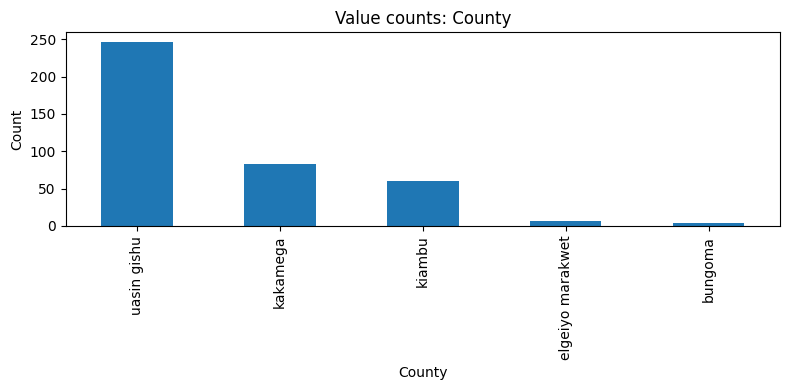

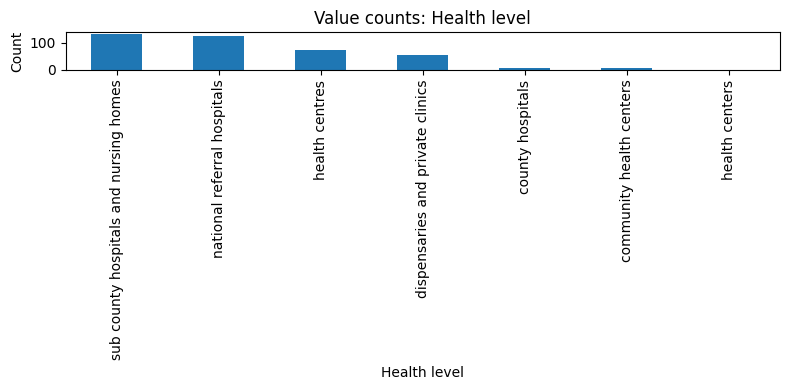

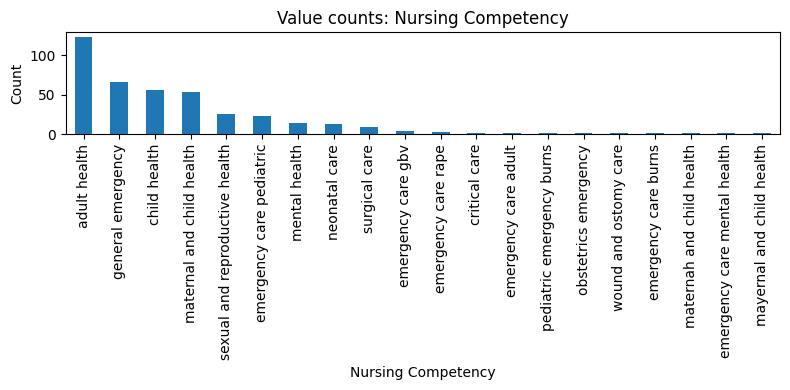

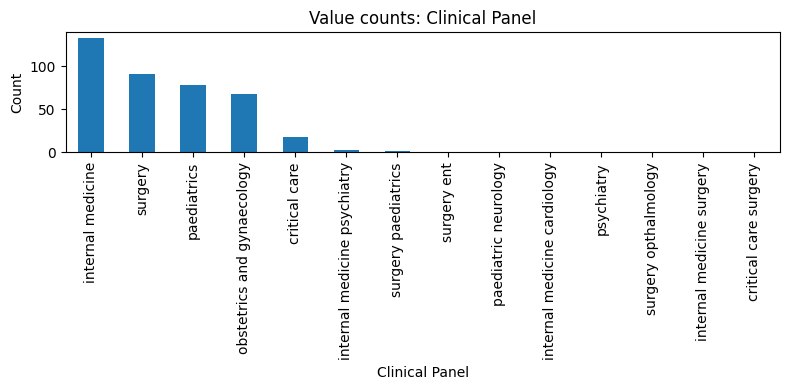

In [9]:
for col in ["County","Health level","Nursing Competency","Clinical Panel"]:
    vc = train_data[col].value_counts()
    plt.figure(figsize=(8,4))
    vc.plot.bar()
    plt.title(f"Value counts: {col}")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()


In [10]:
# Baseline diagnostics: sample examples
for col in ["GPT4.0","LLAMA","GEMINI","DDX SNOMED"]:
    print(f"\n=== Sample from {col} vs Clinician ===")
    sample = train_data.sample(5)[["Master_Index", "Prompt", "Clinician", col]]
    for _, row in sample.iterrows():
        print(f"\nID {row.Master_Index}:\nPROMPT: {row.Prompt[:100]}...\n"
              f"TRUE:   {row.Clinician[:100]}...\n"
              f"PRED({col}): {row[col][:100]}...\n")



=== Sample from GPT4.0 vs Clinician ===

ID ID_MFOYS:
PROMPT: i am a nurse with 2 years of experience in general nursing working in a sub county hospitals and nur...
TRUE:   summary road traffic accident 30 y o involved in a road traffic accident presents in an unconscious ...
PRED(GPT4.0): in the case of a 30 year old female who was brought unconscious following a road accident with signs...


ID ID_IRNIE:
PROMPT: i am a nurse with 15 years of experience in primary care working in a sub county hospitals and nursi...
TRUE:   summary an expectant mother was sent to the laboratory for anc profile her tests were normal except ...
PRED(GPT4.0): in the case of an expectant mother with positive hepatitis b results and hiv on treatment there are ...


ID ID_DFPCN:
PROMPT: i am a nurse with 9 years of experience in general nursing working in a sub county hospitals and nur...
TRUE:   summary a 60 year old female known dm htn for the last 10 years on medication presented with 52 hist...
PRED(GP

In [11]:
scorer = rouge_scorer.RougeScorer(['rouge1','rougeL'], use_stemmer=True)

In [12]:
results = {}
for col in ["GPT4.0","LLAMA","GEMINI"]:
    rouge1, rougeL = [], []
    bleu = []
    for pred, gold in zip(train_data[col], train_data["Clinician"]):
        scores = scorer.score(gold, pred)
        rouge1.append(scores['rouge1'].fmeasure)
        rougeL.append(scores['rougeL'].fmeasure)
        bleu.append(sacrebleu.sentence_bleu(pred, [gold]).score / 100)

    results[col] = {
        'avg_rouge1': sum(rouge1)/len(rouge1),
        'avg_rougeL': sum(rougeL)/len(rougeL),
        'avg_bleu':   sum(bleu)/len(bleu),
    }

import pandas as pd
pd.DataFrame(results).T

,avg_rouge1,avg_rougeL,avg_bleu
GPT4.0,0.162193,0.094534,0.015626
LLAMA,0.228925,0.120404,0.020704
GEMINI,0.191464,0.103193,0.015390


In [13]:
for model in ["GPT4.0","LLAMA","GEMINI","DDX SNOMED"]:
    # ensure no NaNs
    train_data[model] = train_data[model].fillna("")
    # compute
    train_data[f'rougeL_{model}'] = train_data.apply(
        lambda r: scorer.score(str(r['Clinician']), str(r[model]))['rougeL'].fmeasure,
        axis=1
    )

    worst = train_data.nsmallest(10, f'rougeL_{model}')
    print(f"\n=== worst 10 for {model} ===")
    for _, row in worst.iterrows():
        score = row[f'rougeL_{model}']
        print(f"ID {row.Master_Index} → ROUGE-L: {score:.3f}")
        print("  PROMPT:", row.Prompt[:80], "…")
        print("  TRUE:  ", row.Clinician[:80], "…")
        print(f"  PRED ({model}):  {row[model][:80]} …\n")



=== worst 10 for GPT4.0 ===
ID ID_WEFUI → ROUGE-L: 0.026
  PROMPT: i am a nurse working in a dispensaries and private clinics in kakamega county in …
  TRUE:   summary a 30 years old woman presents with a history of being assaulted by her h …
  PRED (GPT4.0):  in this situation where the woman is experiencing domestic violence physical emo …

ID ID_GLHTL → ROUGE-L: 0.033
  PROMPT: i am a nurse working in a national referral hospitals in uasin gishu county in k …
  TRUE:   summary a 32 year old female presents with dysuria urgency and lower abdominal d …
  PRED (GPT4.0):  immediate management for shoulder dystocia shoulder dystocia occurs when the fet …

ID ID_KPNYF → ROUGE-L: 0.035
  PROMPT: i am a nurse working in a dispensaries and private clinics in kiambu county in k …
  TRUE:   summary a 34 year old female presents with sudden severe pelvic pain and heavy v …
  PRED (GPT4.0):  in this case the 4 year old child has never been vaccinated and you are dealing  …

ID ID_OKDQA → ROUGE-

In [14]:
for model in ["GPT4.0","LLAMA","GEMINI","DDX SNOMED"]:
    col = f"rougeL_{model}"
    grouped = (
        train_data
          .groupby("Nursing Competency")
          .agg({col: ["mean","count"]})
          .sort_values(by=(col, "mean"), ascending=True)
    )
    print(f"\n=== {model} performance by Nursing Competency (ascending mean ROUGE-L) ===")
    print(grouped)



=== GPT4.0 performance by Nursing Competency (ascending mean ROUGE-L) ===
                               rougeL_GPT4.0      
                                        mean count
Nursing Competency                                
pediatric emergency burns           0.049946     1
emergency care mental health        0.056581     1
emergency care gbv                  0.071339     4
obstetrics emergency                0.083333     1
neonatal care                       0.087154    13
emergency care pediatric            0.087697    23
emergency care burns                0.088889     1
mental health                       0.091007    14
sexual and reproductive health      0.092922    25
mayernal and child health           0.093023     1
adult health                        0.093915   123
emergency care adult                0.094283     2
surgical care                       0.095257     9
maternal and child health           0.095686    53
child health                        0.095700    56
critica

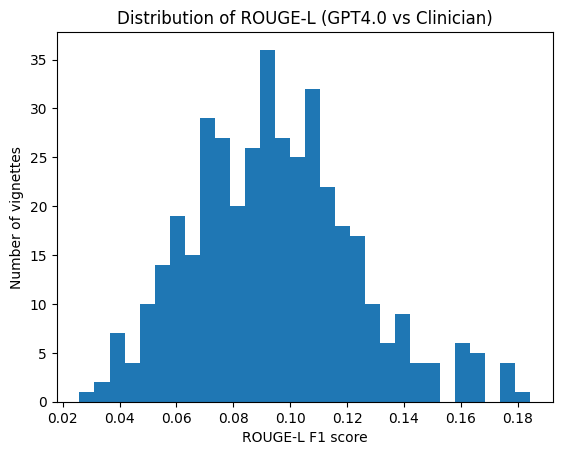

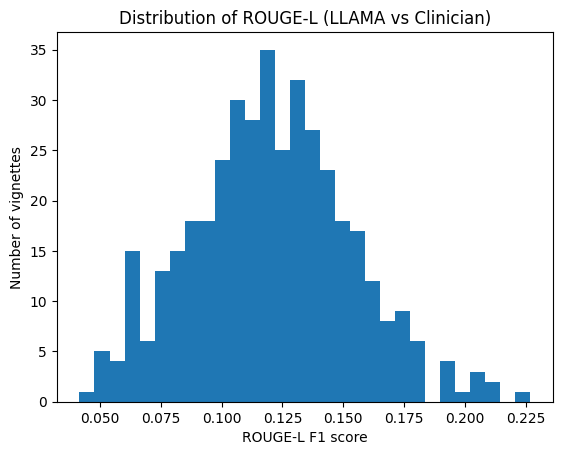

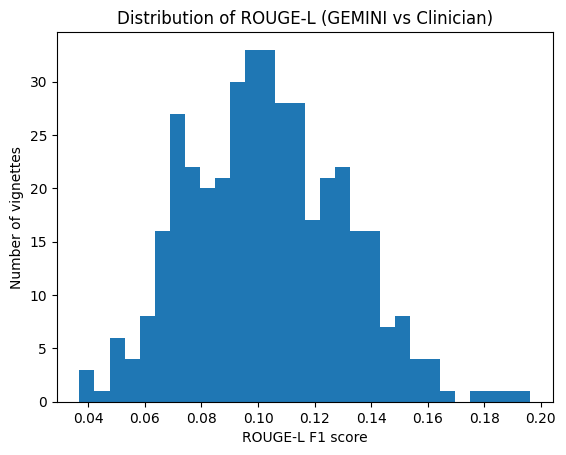

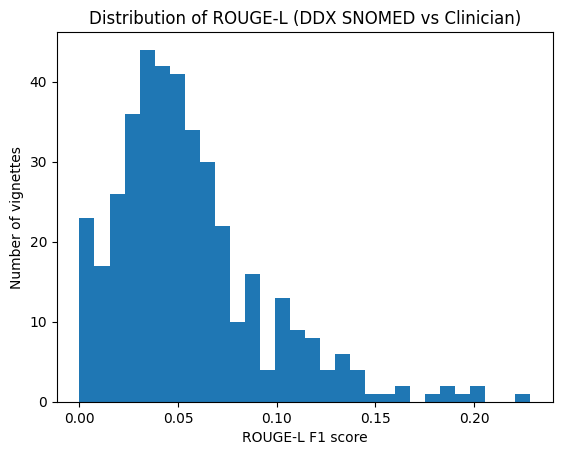

In [15]:
for data in ["GPT4.0","LLAMA","GEMINI","DDX SNOMED"]:
    plt.hist(train_data[f'rougeL_{data}'], bins=30)
    plt.title(f"Distribution of ROUGE-L ({data} vs Clinician)")
    plt.xlabel("ROUGE-L F1 score")
    plt.ylabel("Number of vignettes")
    plt.show()

In [16]:
i = worst.iloc[0]
diff = difflib.unified_diff(
    i.Clinician.split(), i['GPT4.0'].split(),
    fromfile='Clinician', tofile='GPT4.0', lineterm=''
)
print("\n".join(diff))

--- Clinician
+++ GPT4.0
@@ -1,84 +1,923 @@
-summary
-a
-40
-year
-old
-para
-3
-0
-g4
-at
-38
-weeks
+managing
+the
+care
+of
+a
+newborn
+born
+to
+a
+mother
+who
+is
 on
+anti
+tuberculosis
+tb
+medication
+is
+critical
+to
+ensure
+the
+health
+of
+both
+the
+mother
+and
+the
+baby
+the
+management
+of
+such
+cases
+requires
+careful
+planning
+to
+minimize
+the
+risk
+of
+the
+baby
+contracting
+tuberculosis
+while
+also
+managing
+the
+mother’s
+tb
+treatment
+effectively
+here’s
+how
+you
+can
+manage
+the
+baby
+after
+delivery
+and
+the
+precautions
+the
+mother
+should
+take
+1
+managing
+the
+baby
+after
+delivery
+a
+immediate
+care
+of
+the
+newborn
+•
+isolation
+if
+the
+mother
+is
+in
+the
 intensive
 phase
-antitbs
-differentials
+of
+anti
+tb
+treatment
+especially
+if
+she
+is
+smear
+positive
+for
+tb
+or
+has
+an
+active
+case
+of
 pulmonary
 tb
-investigations
-baseline
+it
+s
+essential
+to
+take
+steps
+to
+reduce
+the
+risk
+of
+transmission
+after
+delivery
+e

In [17]:
sample_df = train_data.sample(5, random_state=42)

# 2) For each vignette, print prompt, true text, and every model's prediction
for _, row in sample_df.iterrows():
    print("="*80)
    print(f"ID: {row.Master_Index}\n")
    print("PROMPT:")
    print(row.Prompt, "\n")
    print("TRUE (Clinician):")
    print(row.Clinician, "\n")
    
    # Now compare every model on this same row
    for col in ["GPT4.0","LLAMA","GEMINI","DDX SNOMED"]:
        print(f"[{col}]")
        print(row[col], "\n")


ID: ID_CSMTR

PROMPT:
i am a nurse working in a health centres in kakamega county in kenya a child is brought to mch with a bulging anterior fontanelle the child is two years old and has a fever and a shrill cry could this be meningitis what are the differential diagnoses 

TRUE (Clinician):
summary a 2 year old child brought to the mother child clinic with a bulging anterior fontanelle she also has a fever and a shrill cry concern for meningitis with increased intracranial pressure sepsis encephalitis would manage as follows fix a cannula and administer iv fluids antipyretics for fever analgesics for pain antibiotics for suspected infection nb all doses according to pediatric protocol after stabilizing the patient refer to a higher facility with head ct scan and for further management investigations full hemogram erythrocyte sedimentation rate urea electrolytes and creatinine liver function tests blood slide for malarial parasites lumbar puncture for cerebrospinal fluid analysis radio

## Preprocess and Split Data

In [18]:
train_data.head()

,Master_Index,County,Health level,Years of Experience,Prompt,Nursing Competency,Clinical Panel,Clinician,GPT4.0,LLAMA,GEMINI,DDX SNOMED,rougeL_GPT4.0,rougeL_LLAMA,rougeL_GEMINI,rougeL_DDX SNOMED
0,ID_VBWWP,uasin gishu,sub county hospitals and nursing homes,18.0,i am a nurse with 18 years of experience in ge...,pediatric emergency burns,surgery,summary a 4 year old with 5 superficial burns ...,given your vast experience as a nurse in uasin...,1 immediate treatment protocol for second degr...,here s a response addressing the questions reg...,288514009 burn involving 5 percent of body sur...,0.049946,0.059859,0.062857,0.071429
1,ID_XMBBY,uasin gishu,national referral hospitals,17.0,i am a nurse with 17 years of experience in ge...,child health,paediatrics,summary 6 year old present with vomiting and a...,clinical summary • a 6 year old girl with know...,based on the symptoms and signs you ve describ...,based on the presentation the 6 year old girl ...,420270002 ketoacidosis due to type 1 diabetes ...,0.113980,0.148014,0.100680,0.075472
2,ID_JZNZW,kiambu,sub county hospitals and nursing homes,12.0,i am a nurse with 12 years of experience in ge...,general emergency,internal medicine,summary a 47 year old man presents with severe...,in this case you re dealing with a 47 year old...,firstly i must commend you on your thorough hi...,this 47 year old male presenting with severe r...,13200003 peptic ulcer disorder 25458004 acute ...,0.161435,0.130536,0.136364,0.062016
3,ID_QOQTK,uasin gishu,national referral hospitals,12.0,i am a nurse with 12 years of experience in pr...,critical care,internal medicine,summary 72 year old female with inability to w...,given er s clinical presentation and vitals th...,to me with this query based on the information...,this 92 year old female patient er presents wi...,14760008 constipation finding 419284004 altere...,0.114155,0.144213,0.127139,0.045455
4,ID_ZFJBM,uasin gishu,national referral hospitals,16.0,i am a nurse with 16 years of experience in ge...,adult health,internal medicine,a 22 year old female presents with headache di...,the 22 year old female patient is presenting w...,thank you for presenting this case based on th...,this 22 year old female patient presents with ...,95874006 carbon monoxide poisoning from fire d...,0.174346,0.204593,0.159888,0.066667


In [19]:
train_data = train_data.dropna()

Clean and enhance text data

In [20]:
def clean_text(text):
    # Ensure "100mg" → "100 mg"
    text = re.sub(r'(\d+\.?\d*)\s*([a-zA-Z]+)', r'\1 \2', str(text))
    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    # Remove all punctuation except dot, slash, hyphen
    medical_punct = {'.','/','-'}
    for p in set(string.punctuation) - medical_punct:
        text = text.replace(p, ' ')
    # Collapse any extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# 2) Enrichment function
def enhance_prompt(row):
    prompt_text = row['Prompt'].strip()   # use cleaned prompt
    parts = [
        f"[CASE ID]:          {row['Master_Index']}",
        f"[COUNTY]:           {row['County']}",
        f"[FACILITY LEVEL]:   {row['Health level']}"
    ]
    if pd.notna(row['Nursing Competency']):
        parts.append(f"[COMPETENCY]:       {row['Nursing Competency']}")
    if pd.notna(row['Clinical Panel']):
        parts.append(f"[CLINICAL PANEL]:   {row['Clinical Panel']}")
    if pd.notna(row['Years of Experience']):
        yrs = int(row['Years of Experience'])
        parts.append(f"[EXPERIENCE]:       {yrs} yrs")

    # extract age/gender from the prompt_text
    age_gender = []
    m_age = re.search(r'(\d+)[- ]?(?:year|yr)[- ]?old', prompt_text.lower())
    if m_age:
        age_gender.append(f"Age: {m_age.group(1)}")
    m_gen = re.search(r'\b(male|female|man|woman)\b', prompt_text.lower())
    if m_gen:
        g = m_gen.group(1)
        g = "female" if g == "woman" else "male" if g == "man" else g
        age_gender.append(f"Gender: {g}")
    if age_gender:
        parts.append(f"[PATIENT]:          {' | '.join(age_gender)}")

    header = "\n".join(parts)
    enriched = (
        "Based on clinical reasoning, provide a concise professional assessment:\n\n"
        f"{header}\n"
        f"[PRESENTATION]:     {prompt_text}\n"
    )
    return enriched

# 3) Apply cleaning
train_data['Prompt']    = train_data['Prompt'].apply(clean_text)
test_data['Prompt']     = test_data['Prompt'].apply(clean_text)
train_data['Clinician'] = train_data['Clinician'].apply(clean_text)

# 4) Generate enriched prompts
train_data['EnrichedInput'] = train_data.apply(enhance_prompt, axis=1)

# 5) Inspect
# print(train_data[['Master_Index','EnrichedInput']].head(1).to_string(index=False))
# print(test_data[['Master_Index','Prompt']].head(1).to_string(index=False))
print(train_data['EnrichedInput'].iloc[2])

Based on clinical reasoning, provide a concise professional assessment:

[CASE ID]:          ID_JZNZW
[COUNTY]:           kiambu
[FACILITY LEVEL]:   sub county hospitals and nursing homes
[COMPETENCY]:       general emergency
[CLINICAL PANEL]:   internal medicine
[EXPERIENCE]:       12 yrs
[PATIENT]:          Gender: male
[PRESENTATION]:     i am a nurse with 12 years of experience in general nursing working in a sub county hospitals and nursing homes in kiambu county in kenya forty seven years old man came to casualty supported by two men screaming because of pain upon inquiry he reported that he had severe abdominal pain upper abdominal pain in the gastric area which had started the previous night he had not slept he also reported that this was not the first time that it was happening and he reported a history of pud this time it was severe so on observations the puds were the vitals were within normal range the questions i had were an analgesic first or this patient was sent for lab

In [21]:
train_data['Enhanced_Prompt'] = train_data.apply(enhance_prompt, axis=1)
train_data.head()

,Master_Index,County,Health level,Years of Experience,Prompt,Nursing Competency,Clinical Panel,Clinician,GPT4.0,LLAMA,GEMINI,DDX SNOMED,rougeL_GPT4.0,rougeL_LLAMA,rougeL_GEMINI,rougeL_DDX SNOMED,EnrichedInput,Enhanced_Prompt
0,ID_VBWWP,uasin gishu,sub county hospitals and nursing homes,18.0,i am a nurse with 18 years of experience in ge...,pediatric emergency burns,surgery,summary a 4 year old with 5 superficial burns ...,given your vast experience as a nurse in uasin...,1 immediate treatment protocol for second degr...,here s a response addressing the questions reg...,288514009 burn involving 5 percent of body sur...,0.049946,0.059859,0.062857,0.071429,"Based on clinical reasoning, provide a concise...","Based on clinical reasoning, provide a concise..."
1,ID_XMBBY,uasin gishu,national referral hospitals,17.0,i am a nurse with 17 years of experience in ge...,child health,paediatrics,summary 6 year old present with vomiting and a...,clinical summary • a 6 year old girl with know...,based on the symptoms and signs you ve describ...,based on the presentation the 6 year old girl ...,420270002 ketoacidosis due to type 1 diabetes ...,0.113980,0.148014,0.100680,0.075472,"Based on clinical reasoning, provide a concise...","Based on clinical reasoning, provide a concise..."
2,ID_JZNZW,kiambu,sub county hospitals and nursing homes,12.0,i am a nurse with 12 years of experience in ge...,general emergency,internal medicine,summary a 47 year old man presents with severe...,in this case you re dealing with a 47 year old...,firstly i must commend you on your thorough hi...,this 47 year old male presenting with severe r...,13200003 peptic ulcer disorder 25458004 acute ...,0.161435,0.130536,0.136364,0.062016,"Based on clinical reasoning, provide a concise...","Based on clinical reasoning, provide a concise..."
3,ID_QOQTK,uasin gishu,national referral hospitals,12.0,i am a nurse with 12 years of experience in pr...,critical care,internal medicine,summary 72 year old female with inability to w...,given er s clinical presentation and vitals th...,to me with this query based on the information...,this 92 year old female patient er presents wi...,14760008 constipation finding 419284004 altere...,0.114155,0.144213,0.127139,0.045455,"Based on clinical reasoning, provide a concise...","Based on clinical reasoning, provide a concise..."
4,ID_ZFJBM,uasin gishu,national referral hospitals,16.0,i am a nurse with 16 years of experience in ge...,adult health,internal medicine,a 22 year old female presents with headache di...,the 22 year old female patient is presenting w...,thank you for presenting this case based on th...,this 22 year old female patient presents with ...,95874006 carbon monoxide poisoning from fire d...,0.174346,0.204593,0.159888,0.066667,"Based on clinical reasoning, provide a concise...","Based on clinical reasoning, provide a concise..."


## Train and split data

In [22]:
# def prepare_data_correctly(train_data):
#     """Correct data preparation pipeline"""
    
#     # 1. Define formatting functions
#     def format_clinician_response(response):
#         response = response.lower().strip()
#         if not response.startswith('summary'):
#             if response.startswith('a '):
#                 response = 'summary ' + response[2:]
#             else:
#                 response = 'summary ' + response
#         return response
    
#     def create_enriched_input(row):
#         return f"""County: {row['County']}
# Facility: {row['Health level']}
# Experience: {row['Years of Experience']} years
# Competency: {row['Nursing Competency']}
# Department: {row['Clinical Panel']}

# Case: {row['Prompt']}"""
    
#     # 2. Apply preprocessing BEFORE splitting
#     print("Formatting clinician responses...")
#     train_data['Clinician_Formatted'] = train_data['Clinician'].apply(format_clinician_response)
    
#     print("Creating enriched inputs...")
#     train_data['EnrichedInput'] = train_data.apply(create_enriched_input, axis=1)
    
#     # 3. NOW do the train/test split
#     train_df, eval_df = train_test_split(
#         train_data[['EnrichedInput', 'Clinician_Formatted']], 
#         test_size=0.2, 
#         random_state=42
#     )
    
#     print(f"Training samples: {len(train_df)}")
#     print(f"Evaluation samples: {len(eval_df)}")
    
#     # 4. Convert to datasets
#     train_ds = Dataset.from_pandas(train_df.reset_index(drop=True))
#     eval_ds = Dataset.from_pandas(eval_df.reset_index(drop=True))
    
#     return train_ds, eval_ds

# # Use it like this:
# train_ds, clinician_ds = prepare_data_correctly(train_data)

In [ ]:
train_df, clinician_df = train_test_split(train_data[['EnrichedInput', 'Clinician']], test_size=0.2, random_state=42)
train_ds = Dataset.from_pandas(train_df.reset_index(drop=True))
clinician_ds = Dataset.from_pandas(clinician_df.reset_index(drop=True))

tokenizer = T5Tokenizer.from_pretrained('t5-large')
# tokenizer = AutoTokenizer.from_pretrained('QizhiPei/BioT5-base')
# tokenizer = AutoTokenizer.from_pretrained('michiyasunaga/BioLinkBERT-large') # chagne to base if problems arise
# tokenizer2 = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

model = T5ForConditionalGeneration.from_pretrained('t5-large')
# model = T5ForConditionalGeneration.from_pretrained(
#     'QizhiPei/BioT5-base',
#     torch_dtype=torch.float32,
#     # device_map="auto",
#     low_cpu_mem_usage=False,
# )
# model = AutoModelForCausalLM.from_pretrained('michiyasunaga/BioLinkBERT-large')
# model2 = AutoModelForCausalLM.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

lora_config = LoraConfig(
    task_type=TaskType.SEQ_2_SEQ_LM,
    r=16,
    lora_alpha=32,
    lora_dropout=0.1,
    bias="none",
    target_modules=["q", "v", "k", "o"],  
    inference_mode=False,
    modules_to_save=["embed_tokens", "lm_head"]
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/2.95G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

trainable params: 101,056,512 || all params: 838,724,608 || trainable%: 12.0488


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.gradient_checkpointing_enable()
MAX_IN, MAX_OUT = 512, 256

def tokenize_function(batch):
    inputs = tokenizer(
            ["Generate clinical response: " + text for text in batch['EnrichedInput']], 
            max_length=MAX_IN, 
            padding='max_length', 
            truncation=True,
            return_tensors="pt"
        )
        
    # Use target tokenizer context for T5
    with tokenizer.as_target_tokenizer():
        outputs = tokenizer(
            batch['Clinician'], 
            max_length=MAX_OUT, 
            padding='max_length', 
            truncation=True,
            return_tensors="pt"
        )

    labels = outputs['input_ids'].clone()
    labels[labels == tokenizer.pad_token_id] = -100
    
    return {
        'input_ids': inputs['input_ids'],
        'attention_mask': inputs['attention_mask'],
        'labels': labels
    }

# Apply tokenization
tokenized_train = train_ds.map(
    tokenize_function, 
    batched=True, 
    batch_size=500, 
    remove_columns=train_ds.column_names, 
    desc="Tokenizing train data",
)

tokenized_eval = clinician_ds.map(
    tokenize_function, 
    batched=True, 
    batch_size=500, 
    remove_columns=clinician_ds.column_names, 
    desc="Tokenizing eval data"
)

# Set torch format
tokenized_train.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
tokenized_eval.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

Tokenizing train data:   0%|          | 0/240 [00:00<?, ? examples/s]

Tokenizing eval data:   0%|          | 0/60 [00:00<?, ? examples/s]

In [68]:
# Optimized compute_metrics function
def compute_metrics(eval_preds):
    predictions, labels = eval_preds
    
    # Handle tensor conversion more efficiently
    if isinstance(predictions, tuple):
        predictions = predictions[0]
    
    if hasattr(predictions, 'cpu'):
        predictions = predictions.cpu().numpy()
    
    # Convert logits to token IDs efficiently
    if predictions.ndim == 3:
        predictions = np.argmax(predictions, axis=-1)
    
    # Decode in batches for memory efficiency
    decoded_preds = []
    decoded_labels = []
    
    batch_size = 32
    for i in range(0, len(predictions), batch_size):
        batch_preds = predictions[i:i+batch_size]
        batch_labels = labels[i:i+batch_size]
        
        decoded_preds.extend(tokenizer.batch_decode(batch_preds, skip_special_tokens=True))
        
        # Process labels
        for label_seq in batch_labels:
            label_seq = np.where(label_seq != -100, label_seq, tokenizer.pad_token_id)
            decoded_labels.append(tokenizer.decode(label_seq, skip_special_tokens=True))
    
    # Compute ROUGE scores
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    
    rouge_scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}
    
    for pred, label in zip(decoded_preds, decoded_labels):
        if pred and label:
            scores = scorer.score(label, pred)
            for metric in rouge_scores:
                rouge_scores[metric].append(scores[metric].fmeasure)
    
    return {
        metric: np.mean(scores) if scores else 0.0
        for metric, scores in rouge_scores.items()
    }

In [ ]:
# # Training arguments OUTSIDE the function
args = Seq2SeqTrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8,
    warmup_ratio=0.1,
    evaluation_strategy="epoch",
    eval_steps=100,
    save_strategy="epoch",
    save_steps=200,
    logging_steps=55,
    fp16=False,
    bf16=False,
    learning_rate=5e-4,
    gradient_accumulation_steps=4,
    dataloader_num_workers=1,
    generation_num_beams=1,
    load_best_model_at_end=True,
    greater_is_better=True,
    remove_unused_columns=True,
    ignore_data_skip=True,
    predict_with_generate=True,
    metric_for_best_model="eval_rougeL",
    report_to='wandb',
    run_name='BioT5',
    dataloader_pin_memory=False,
    gradient_checkpointing=False,
    optim="adamw_torch_fused",
    weight_decay=0.01,
    max_grad_norm=1.0,
    lr_scheduler_type="linear",
    # warmup_steps=100,
)

early_stopping = EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold=0.001)

trainer = Trainer(
    model=model,
    train_dataset=tokenized_train,  
    eval_dataset=tokenized_eval,    
    args=args,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    # callbacks=[early_stopping]
)

print("Training...")
train_time = time.time()
clear_memory()
trainer.train()
clear_memory()
time_duration = time.time() - train_time
print(f"Training time: {time_duration / 60:.2f} minutes")

eval_results = trainer.evaluate()
print("Evaluation results:")
for key, value in eval_results.items():
    print(f"{key}: {value:.4f}")

model_save_path = "./Clinical-Reasoning-AI-Bot"
trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)
print("Model saved to:", model_save_path)

Training...


  0%|          | 0/45 [00:00<?, ?it/s]

In [53]:
# Enhanced overfitting check
def check_overfitting_enhanced(trainer):
    log_history = trainer.state.log_history
    
    train_losses = [log['loss'] for log in log_history if 'loss' in log]
    eval_losses = [log['eval_loss'] for log in log_history if 'eval_loss' in log]
    
    if len(eval_losses) >= 3:
        recent_eval = eval_losses[-3:]
        recent_train = train_losses[-3:]
        
        # Check for overfitting
        if all(recent_eval[i] > recent_eval[i-1] for i in range(1, len(recent_eval))):
            print("WARNING: Model is overfitting!")
            print(f"Last 3 eval losses: {recent_eval}")
            return True
        
        # Check for underfitting
        if recent_train[-1] > recent_train[0] and recent_eval[-1] > recent_eval[0]:
            print("CAUTION: Model may be underfitting")
            return True
    
    print("No overfitting detected")
    return False

check_overfitting_enhanced(trainer)

IndexError: list index out of range

In [54]:
# Load ROUGE metric
rouge = load_metric("rouge")

# Get predictions
pred_output = trainer.predict(tokenized_eval)
preds = pred_output.predictions

# Fix: Handle tuple predictions
if isinstance(preds, tuple):
    preds = preds[0]  # Take the first element (usually the logits)

# Convert to numpy if it's a tensor
if hasattr(preds, 'cpu'):
    preds = preds.cpu().numpy()

# Fix: Convert logits to token IDs
if preds.ndim == 3:  # Shape: [batch_size, seq_len, vocab_size]
    preds = np.argmax(preds, axis=-1)  # Get token IDs

# Now decode
decoded = tokenizer.batch_decode(preds, skip_special_tokens=True)

# Get references (need to decode labels too)
refs = []
for ex in tokenized_eval:
    labels = ex["labels"]
    # Replace -100 with pad token for decoding
    labels = np.where(np.array(labels) != -100, labels, tokenizer.pad_token_id)
    ref_text = tokenizer.decode(labels, skip_special_tokens=True)
    refs.append(ref_text)

# Compute ROUGE
results = rouge.compute(predictions=decoded, references=refs)
print("ROUGE Results:", results)

  0%|          | 0/8 [00:00<?, ?it/s]

ROUGE Results: {'rouge1': 0.2509427682174041, 'rouge2': 0.03683899169483003, 'rougeL': 0.18272150976081356, 'rougeLsum': 0.18284310446667895}


In [59]:
def generate_clinical_assessments_working(test_data, model, tokenizer, batch_size=8):
    """Working generation function that returns the correct number of responses"""
    
    print("Checking test data...")
    print(f"Test data shape: {test_data.shape}")

    prompt_column = 'Prompt'
    model.eval()
    all_responses = []
    
    # Process each example individually to ensure we get all responses
    with torch.no_grad():
        for i in tqdm(range(0, len(test_data), batch_size), desc="Generating responses"):
            batch_end = min(i + batch_size, len(test_data))
            batch_prompts = []
            
            # Prepare batch
            for j in range(i, batch_end):
                prompt = str(test_data.iloc[j][prompt_column])
                input_text = f"Generate clinical response: {prompt}"
                batch_prompts.append(input_text)
            
            # Tokenize
            inputs = tokenizer(
                input_text,
                max_length=512,
                padding=True,
                truncation=True,
                return_tensors="pt"
            ).to(model.device)
            
            # Generate
            outputs = model.generate(
                **inputs,
                max_length=640,
                min_length=50,
                num_beams=3,
                early_stopping=True,
                do_sample=False,
                temperature=0.8,
                top_p=0.9,
                top_k=50,
                repetition_penalty=1.2,
                length_penalty=1.0,
                no_repeat_ngram_size=3,
                pad_token_id=tokenizer.pad_token_id,
                eos_token_id=tokenizer.eos_token_id,
                use_cache=True
            )
            
            # Decode
            response = tokenizer.decode(outputs[0], skip_special_tokens=True)
            cleaned_responses = []
            for response in responses:
                if "generate clinical response:" in response.lower():
                    response = response.lower().split("generate clinical response:")[-1]
                response = response.strip()
                cleaned_responses.append(response)
            
            all_responses.extend(cleaned_responses)
            
            # Memory cleanup
            if (i // batch_size) % 5 == 0:
                torch.cuda.empty_cache()
    
    print(f"Generated {len(all_responses)} responses")
    
    if len(all_responses) != len(test_data):
        while len(all_responses) < len(test_data):
            all_responses.append("")
        all_responses = all_responses[:len(test_data)]
    
    return all_responses

# Use the working function
clear_memory()
print("Starting generation...")
responses = generate_clinical_assessments_working(test_data, model, tokenizer)

# Verify we have the right number of responses
print(f"Generated {len(responses)} responses for {len(test_data)} examples")

# Assign to test_data
test_data_copy = test_data['Clinician']
test_data['Clinician'] = responses

# Check some examples
print("\nSample generations:")
for i in range(min(3, len(test_data))):
    print(f"\n--- Example {i+1} ---")
    prompt_col = 'Prompt' if 'Prompt' in test_data.columns else 'CleanPrompt'
    print(f"Input: {test_data[prompt_col].iloc[i][:100]}...")
    print(f"Generated: {test_data['Clinician'].iloc[i]}")

# Save to CSV
submission = test_data[['Master_Index', 'Clinician']]
submission.to_csv("submission.csv", index=False)
print(f"\nSaved submission with {len(submission)} predictions to submission.csv")

Starting generation...
Checking test data...
Test data shape: (100, 8)


Generating responses: 100%|██████████| 13/13 [02:36<00:00, 12.06s/it]


Generated 1300 responses
Generated 100 responses for 100 examples

Sample generations:

--- Example 1 ---
Input: i am a nurse with 2 years of experience in general nursing working in a sub county hospitals and nur...
Generated: i am a nurse with 2 years experience i am a nurse with 2 years experience i am a nurse with 2 years experience i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i

In [65]:
def evaluate_rouge_scores(predictions, references, save_detailed=True):
    """
    Evaluate ROUGE scores for each prediction and overall
    """
    from rouge_score import rouge_scorer
    
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    
    individual_scores = []
    overall_scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}
    
    print("Evaluating ROUGE scores for each prediction...")
    
    for i, (pred, ref) in enumerate(tqdm(zip(predictions, references), total=len(predictions))):
        scores = scorer.score(ref, pred)
        
        individual_score = {
            'index': i,
            'rouge1': scores['rouge1'].fmeasure,
            'rouge2': scores['rouge2'].fmeasure,
            'rougeL': scores['rougeL'].fmeasure,
            'prediction': pred,
            'reference': ref
        }
        
        individual_scores.append(individual_score)
        
        # Collect for overall scores
        overall_scores['rouge1'].append(scores['rouge1'].fmeasure)
        overall_scores['rouge2'].append(scores['rouge2'].fmeasure)
        overall_scores['rougeL'].append(scores['rougeL'].fmeasure)
    
    # Calculate overall averages
    overall_avg = {
        'rouge1': np.mean(overall_scores['rouge1']),
        'rouge2': np.mean(overall_scores['rouge2']),
        'rougeL': np.mean(overall_scores['rougeL'])
    }
    
    print("\n=== OVERALL ROUGE SCORES ===")
    print(f"ROUGE-1: {overall_avg['rouge1']:.4f}")
    print(f"ROUGE-2: {overall_avg['rouge2']:.4f}")
    print(f"ROUGE-L: {overall_avg['rougeL']:.4f}")
    
    # Save detailed results
    if save_detailed:
        detailed_df = pd.DataFrame(individual_scores)
        detailed_df.to_csv('rouge_detailed_results.csv', index=False)
        print(f"\nDetailed results saved to 'rouge_detailed_results.csv'")
        
        # Show top 10 best and worst predictions
        print("\n=== TOP 10 BEST PREDICTIONS (by ROUGE-1) ===")
        best_predictions = detailed_df.nlargest(10, 'rouge1')
        for _, row in best_predictions.iterrows():
            print(f"Index {row['index']}: ROUGE-1 = {row['rouge1']:.4f}")
            print(f"Prediction: {row['prediction'][:100]}...")
            print(f"Reference: {row['reference'][:100]}...")
            print("-" * 50)
        
        print("\n=== TOP 10 WORST PREDICTIONS (by ROUGE-1) ===")
        worst_predictions = detailed_df.nsmallest(10, 'rouge1')
        for _, row in worst_predictions.iterrows():
            print(f"Index {row['index']}: ROUGE-1 = {row['rouge1']:.4f}")
            print(f"Prediction: {row['prediction'][:100]}...")
            print(f"Reference: {row['reference'][:100]}...")
            print("-" * 50)
    
    return overall_avg, individual_scores

def analyze_generation_quality(predictions, references):
    """
    Analyze the quality of generations
    """
    print("\n=== GENERATION QUALITY ANALYSIS ===")
    
    # Check for repetitive patterns
    repetitive_count = 0
    empty_count = 0
    short_count = 0
    
    for pred in predictions:
        # Check for repetitive patterns
        words = pred.split()
        if len(words) > 10:
            word_counts = Counter(words)
            most_common = word_counts.most_common(1)[0]
            if most_common[1] > len(words) * 0.3:  # If any word appears >30% of the time
                repetitive_count += 1
        
        # Check for empty or very short responses
        if len(pred.strip()) < 10:
            empty_count += 1
        elif len(pred.split()) < 5:
            short_count += 1
    
    print(f"Repetitive generations: {repetitive_count}/{len(predictions)} ({repetitive_count/len(predictions)*100:.1f}%)")
    print(f"Empty/very short generations: {empty_count}/{len(predictions)} ({empty_count/len(predictions)*100:.1f}%)")
    print(f"Short generations (<5 words): {short_count}/{len(predictions)} ({short_count/len(predictions)*100:.1f}%)")
    
    # Average length analysis
    avg_length = np.mean([len(pred.split()) for pred in predictions])
    print(f"Average generation length: {avg_length:.1f} words")
    
    return {
        'repetitive': repetitive_count,
        'empty': empty_count,
        'short': short_count,
        'avg_length': avg_length
    }

test_data_copy = pd.read_csv('data/test.csv')
evaluate_rouge_scores(responses, train_data['Clinician'])

Evaluating ROUGE scores for each prediction...


100%|██████████| 100/100 [00:00<00:00, 135.42it/s]



=== OVERALL ROUGE SCORES ===
ROUGE-1: 0.0214
ROUGE-2: 0.0016
ROUGE-L: 0.0194

Detailed results saved to 'rouge_detailed_results.csv'

=== TOP 10 BEST PREDICTIONS (by ROUGE-1) ===
Index 91: ROUGE-1 = 0.1327
Prediction: i am an 8 year old female i am a nurse with 17 years of experience in the emergency department and i...
Reference: summary a 16 year old female patient with a complaint of passing hard melena stool swelling in the a...
--------------------------------------------------
Index 10: ROUGE-1 = 0.1069
Prediction: i am a i am a i am a patient with a history of cerebrovascular accident i am a nurse i am a i am a n...
Reference: a 20 year old male with a history of bee stings generalized body swelling sick looking gcs of 7 15 f...
--------------------------------------------------
Index 34: ROUGE-1 = 0.1027
Prediction: i am a nurse with 9 years of experience in general nursing i am a nurse with 9 years of experience i...
Reference: summary 15 year old with a history of abdominal 

({'rouge1': 0.021366956752450535,
  'rouge2': 0.0015787196510042318,
  'rougeL': 0.01938839343320321},
 [{'index': 0,
   'rouge1': 0.01680672268907563,
   'rouge2': 0.0,
   'rougeL': 0.01680672268907563,
   'prediction': 'i am a nurse with 2 years experience i am a nurse with 2 years experience i am a nurse with 2 years experience i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i am i 